1. Generating CSV Data

In [1]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n_train_samples = 1000
n_test_samples = 200

# Total number of samples (training + testing)
n_samples = n_train_samples + n_test_samples

# Generate random data for the given features
data = {
    'temperature': np.random.uniform(20, 100, n_samples),  # Random temperatures between 20°C and 100°C
    'doping_concentration': np.random.uniform(1e16, 1e18, n_samples),  # Doping concentration (atoms/cm³)
    'thickness_oxide_nitride_oxide': np.random.uniform(3.0, 10.0, n_samples),  # Thickness in nm
    'gate_metal_work_function': np.random.uniform(4.0, 5.5, n_samples),  # Work function in eV
    'program_voltage': np.random.uniform(15, 25, n_samples),  # Program voltage in V
    'erase_voltage': np.random.uniform(10, 20, n_samples),  # Erase voltage in V
    'channel_thickness': np.random.uniform(5.0, 15.0, n_samples),  # Channel thickness in nm
    'tunnel_oxide_thickness': np.random.uniform(1.5, 5.0, n_samples),  # Tunnel oxide thickness in nm
    'metal_gate_work_function': np.random.uniform(4.0, 5.5, n_samples),  # Work function in eV
}

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Generate the 'initial_threshold_voltage' as a function of the above features with added noise
df['initial_threshold_voltage'] = (
    0.02 * df['temperature'] +
    1e-17 * df['doping_concentration'] +
    0.05 * df['thickness_oxide_nitride_oxide'] +
    0.04 * df['gate_metal_work_function'] +
    0.03 * df['program_voltage'] -
    0.02 * df['erase_voltage'] +
    0.06 * df['channel_thickness'] +
    0.07 * df['tunnel_oxide_thickness'] +
    0.05 * df['metal_gate_work_function'] +
    np.random.normal(0, 0.3, n_samples)  # Adding some noise
)

# Assign the last 20% of samples as test data by adding a column to indicate "train" or "test"
df['data_type'] = ['train'] * n_train_samples + ['test'] * n_test_samples

# Save the DataFrame to a CSV file
csv_file_name = 'nand_flash_initial_threshold_data.csv'
df.to_csv(csv_file_name, index=False)

print(f"Generated training and testing data saved to {csv_file_name}")


Generated training and testing data saved to nand_flash_initial_threshold_data.csv


2. Load and Prepare the Data

In [2]:
import pandas as pd

# Load the CSV file
data = pd.read_csv('nand_flash_initial_threshold_data.csv')

# Separate the training and testing data based on the 'data_type' column
train_data = data[data['data_type'] == 'train'].drop('data_type', axis=1)
test_data = data[data['data_type'] == 'test'].drop('data_type', axis=1)

# Split training data into input (X_train) and output (y_train)
X_train = train_data.drop('initial_threshold_voltage', axis=1)
y_train = train_data['initial_threshold_voltage']

# Split testing data into input (X_test) and output (y_test)
X_test = test_data.drop('initial_threshold_voltage', axis=1)
y_test = test_data['initial_threshold_voltage']

print("Training and testing data loaded and split successfully.")


Training and testing data loaded and split successfully.


3. Preprocess and Train the Model

In [3]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Step 1: Scale the Input Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Define an Advanced Neural Network Model
model = Sequential()

# Input Layer
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Hidden Layer 1
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Hidden Layer 2
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Hidden Layer 3
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(1, activation='linear'))  # Linear activation for regression

# Step 3: Compile the Model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Step 4: Learning Rate Scheduler to Improve Training
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=0.00001)

# Step 5: Train the Model
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_test_scaled, y_test),
                    epochs=200,
                    batch_size=32,
                    callbacks=[lr_reduction])

# Step 6: Save the Model for Future Predictions
model.save('advanced_nn_initial_threshold_model.h5')

# Step 7: Evaluate the Model on Test Data
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f'Mean Absolute Error on test set: {mae}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 70.0297 - mae: 7.9415 - val_loss: 60.8465 - val_mae: 7.3560 - learning_rate: 0.0010
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 58.3800 - mae: 7.4051 - val_loss: 50.0261 - val_mae: 6.6113 - learning_rate: 0.0010
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 48.4849 - mae: 6.6812 - val_loss: 39.6305 - val_mae: 5.8600 - learning_rate: 0.0010
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 35.2556 - mae: 5.6311 - val_loss: 25.3376 - val_mae: 4.5805 - learning_rate: 0.0010
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 21.8751 - mae: 4.2458 - val_loss: 11.9828 - val_mae: 3.0465 - learning_rate: 0.0010
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 13.3096 - mae: 3.0775 - val_loss: 5.7561 - val_mae: 1.9808 - learning_rate: 0.0010
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.3413 - mae: 2.2232 - val_loss: 2.5149 - val_mae: 1.2809 - learning_rate: 0.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1075 - mae: 0.2617 
Mean Absolute Error on test set: 0.2553578317165375


4. Plotting Loss vs Epochs

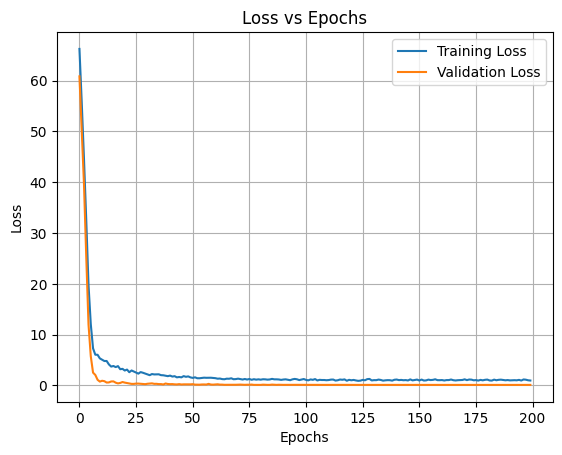

In [4]:
import matplotlib.pyplot as plt

# Plot the Loss vs Epochs
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot the loss curve
plot_loss(history)

5.Evaluating the Model on Testing Data

In [5]:
# Evaluate the model on the test data
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f'Mean Absolute Error on the test set: {mae}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1075 - mae: 0.2617 
Mean Absolute Error on the test set: 0.2553578317165375


6.Comparing Predictions: Looking at a Few Predicted vs Actual Values

In [6]:
# Get predictions on the test data
y_pred = model.predict(X_test_scaled)

# Compare first 5 predictions with actual values
print("Predicted vs Actual Initial Threshold Voltage Values:")
for i in range(5):
    print(f"Sample {i+1}: Predicted = {y_pred[i][0]:.4f}, Actual = {y_test.iloc[i]:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted vs Actual Initial Threshold Voltage Values:
Sample 1: Predicted = 11.8191, Actual = 12.0993
Sample 2: Predicted = 4.1203, Actual = 3.9876
Sample 3: Predicted = 8.5373, Actual = 8.5561
Sample 4: Predicted = 4.1976, Actual = 4.2187
Sample 5: Predicted = 11.0331, Actual = 10.6428


7.Visualization: Actual vs Predicted Values

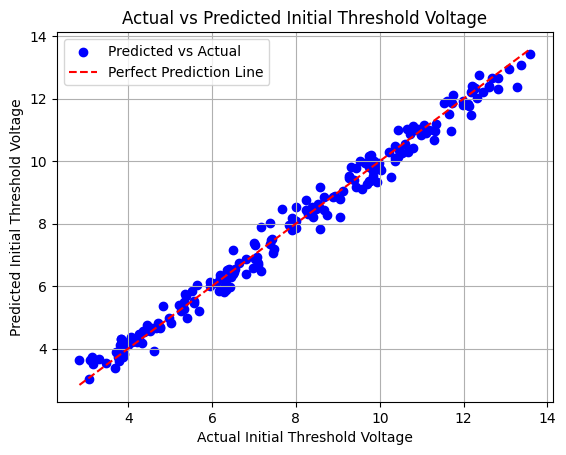

In [7]:
# Plot Actual vs Predicted values
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction Line')
plt.title('Actual vs Predicted Initial Threshold Voltage')
plt.xlabel('Actual Initial Threshold Voltage')
plt.ylabel('Predicted Initial Threshold Voltage')
plt.legend()
plt.grid(True)
plt.show()

8.Calculate residuals

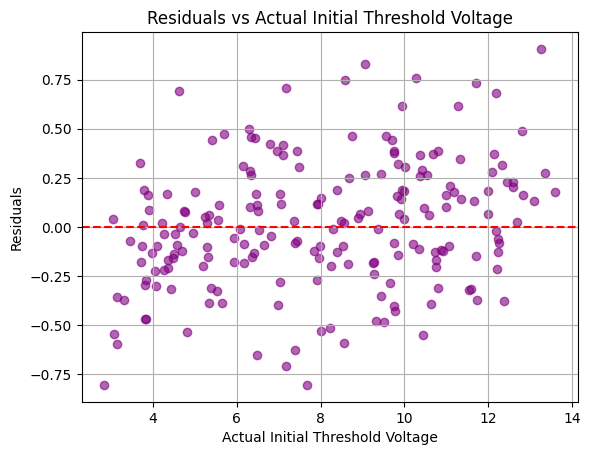

Mean of Residuals: 0.0122
Standard Deviation of Residuals: 0.3220


In [8]:
# Calculate residuals
residuals = y_test - y_pred.flatten()

# Plot Residuals
plt.scatter(y_test, residuals, color='purple', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Actual Initial Threshold Voltage')
plt.xlabel('Actual Initial Threshold Voltage')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Print basic statistics of residuals
print(f'Mean of Residuals: {np.mean(residuals):.4f}')
print(f'Standard Deviation of Residuals: {np.std(residuals):.4f}')